In [1]:
!pip install tensorflow_text

     |████████████████████████████████| 4.4 MB 5.3 MB/s 


In [2]:

import pandas as pd
import numpy as np
import os, io, json
import pickle

import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_text as tf_text
from tensorflow.keras import models, layers, preprocessing as kprocessing

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:

try: # detect TPUs
  tpu = None
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
  #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  strategy = tf.distribute.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO
Number of accelerators:  1


In [4]:
pth_1 =  "/content/drive/MyDrive/Dataset/Dakshina/hi/hi.translit.sampled.train.tsv"

In [4]:
def load_data(path):
  
  df = pd.read_csv(pth_1,sep="\t",names=["Hindi","roman","freq"]) 
  df = df[['Hindi','roman']]
  hindi = np.asarray(df['Hindi'],dtype = str)
  roman = np.asarray(df['roman'],dtype =str)
  #hindi = hindi.astype(str)
  #roman = roman.astype(str)
  tokenizer = tf_text.UnicodeCharTokenizer()
  inp = tokenizer.tokenize([hi for hi in hindi])
  tokenizer.
  targ = tokenizer.tokenize([targ for targ in roman])
  #inp = [np.asarray([i for i in inp],dtype=np.str) for inp in hindi]
  #targ = [["<sos>"]+[j for j in targ]+['<eos>'] for targ in roman]

  return  inp,targ

In [10]:
tokenizer = tf_text.UnicodeCharTokenizer()
tokenizer.tokenize(['abc'])
tokenizer.

<tf.RaggedTensor [[97, 98, 99]]>

In [5]:
inp,targ = load_data(pth_1)

In [ ]:
x = inp[0]
x = x.numpy()
x = x.tolist()
x

[2309, 2306]

In [9]:
tokens = inp[:64]

In [5]:
df = pd.read_csv(pth_1,sep="\t",names=["Hindi","roman","freq"]) 
df = df[['Hindi','roman']]
hindi = df['Hindi']
tokenizer_hi = Tokenizer(
    char_level=True,oov_token='<UNK>'
)
tokenizer_hi.fit_on_texts(hindi)
vocab_hi = tokenizer_hi.word_index
text_hi = tokenizer_hi.texts_to_sequences(hindi)
#text_hi = tf.ragged.stack(text)
x = kprocessing.sequence.pad_sequences(text_hi, 
                     padding="post", truncating="post",)

'अ'

In [9]:
tokenizer_en = Tokenizer(
    char_level=True,oov_token='<UNK>',  
)
roman = np.asarray(df['roman'],dtype = str)

tokenizer_en.fit_on_texts(roman)
text_en = tokenizer_en.texts_to_sequences(roman)



In [10]:
#tokenizer_en.index_word[0] = ''

start_token = len(tokenizer_en.index_word)+1
end_token = len(tokenizer_en.index_word)+2
print(start_token,end_token)
new_text_en = []
for i in text_en:
  i = [start_token] + i + [end_token]
  new_text_en.append(i)

tokenizer_en.index_word[start_token] = '<sos>'
tokenizer_en.word_index['<sos>'] = start_token
tokenizer_en.index_word[end_token] = '<eos>'
tokenizer_en.word_index['<eos>'] = end_token

y = kprocessing.sequence.pad_sequences(new_text_en, 
                     padding="post", truncating="post")

28 29


{0: '',
 '<UNK>': 1,
 'a': 2,
 'b': 19,
 'c': 21,
 'd': 11,
 'e': 9,
 'f': 24,
 'g': 20,
 'h': 5,
 'i': 4,
 'j': 22,
 'k': 12,
 'l': 13,
 'm': 15,
 'n': 3,
 'o': 10,
 'p': 17,
 'q': 27,
 'r': 6,
 's': 8,
 't': 7,
 'u': 14,
 'v': 18,
 'w': 23,
 'x': 26,
 'y': 16,
 'z': 25}

In [82]:
tokenizer_en.index_word[1]

'<UNK>'

In [17]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [39]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size
    
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    
    self.gru1 = tf.keras.layers.Bidirectional( tf.keras.layers.GRU(units=self.enc_units, dropout=0.5,return_sequences=True,return_state=True))
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   dropout=0.4,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(units=self.enc_units,use_bias=False)
  def call(self, tokens, state=None):
    #tokens = self.input1(tokens)
    #shape_checker = ShapeChecker()
    #shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    #shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    
    output, s1,s2 = self.gru1(vectors, initial_state=state)
    
    output, state = self.gru(output, initial_state=state)
    state = tf.keras.layers.concatenate([s1,s2,state], axis=1)
    state = self.dense(state)
    
    #shape_checker(output, ('batch', 's', 'enc_units'))
    #shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [23]:
embedding_dim =256
units =1024

In [38]:
# Convert the input text to tokens.
example_tokens = x[:64]

# Encode the input sequence.
encoder = Encoder(len(vocab_hi),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

#print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

(64, 1024)
Input batch tokens, shape (batch, s): (64, 19)
Encoder output, shape (batch, s, units): (64, 19, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [43]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    
    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    # ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    #('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    #context_vector, ('batch', 't', 'value_units'))
    #attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [44]:
attention_layer = BahdanauAttention(units)
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 19)


Text(0.5, 1.0, 'Mask')

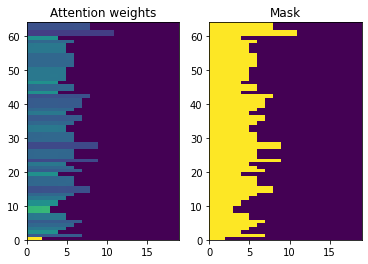

In [23]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [42]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

  
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units, dropout=0.25,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    self.gru2 = tf.keras.layers.GRU(self.dec_units, dropout=0.6,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)


  def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  
    #if state is not None:
      
  # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    #shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
    rnn_output, s1 = self.gru(vectors, initial_state=state)
    rnn_output, state = self.gru2(rnn_output, initial_state=state)
    #shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    #shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  #shape_checker(context_vector, ('batch', 't', 'dec_units'))
  #shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
 # shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
  #shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [45]:
decoder = Decoder((len(tokenizer_en.index_word)+1),
                  embedding_dim, units)

In [46]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = y[:64]

#start_index = token.index('[START]')
first_token = tf.constant([[len(tokenizer_en.index_word)]] * example_output_tokens.shape[0])

In [47]:
decoder.output_vocab_size, len(tokenizer_en.word_index)

(30, 29)

In [48]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 30)
state shape: (batch_size, dec_units) (64, 1024)


In [48]:
sampled_token = tf.random.categorical(dec_result.logits[:,0,:],num_samples=1)
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=sampled_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)


In [49]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    #shape_checker = ShapeChecker()
    #shape_checker(y_true, ('batch', 't'))
    #shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    #shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    #shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [50]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_vocab,
               output_text_vocab, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    self.input_text_vocab = input_text_vocab
    self.output_text_vocab = output_text_vocab

    encoder = Encoder((len(self.input_text_vocab)+1),
                      embedding_dim, units)
    decoder = Decoder((len(output_text_vocab)+1),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    
    self.use_tf_function = use_tf_function
    #self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    #self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)
  def _preprocess(self, input_tokens, target_tokens):
    #self.shape_checker(input_text, ('batch',))
    #self.shape_checker(target_text, ('batch',))

    # Convert the text to token IDs
    #input_tokens = self.input_text_processor(input_text)
    #target_tokens = self.output_text_processor(target_text)
    #self.shape_checker(input_tokens, ('batch', 's'))
    #self.shape_checker(target_tokens, ('batch', 't'))

    # Convert IDs to masks.
    input_mask = input_tokens != 0
    #self.shape_checker(input_mask, ('batch', 's'))

    target_mask = target_tokens != 0
    #self.shape_checker(target_mask, ('batch', 't'))

    return input_tokens, input_mask, target_tokens, target_mask
  def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = target_tokens.shape[1]

    with tf.GradientTape() as tape:
    # Encode the input
      enc_output, enc_state = self.encoder(input_tokens)
      #self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
      #self.shape_checker(enc_state, ('batch', 'enc_units'))

      #  Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
      dec_state = enc_state
      loss = tf.constant(0.0)

      for t in range(max_target_length-1):
        # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target the target for the decoder's next prediction.
        
        new_tokens = target_tokens[:, t:t+2]
        step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
        loss = loss + step_loss

    # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}


  def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]
    
    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    #self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    #self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    #self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state
  
  @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None]),
                               tf.TensorSpec(dtype=tf.int32, shape=[None])]])
  def _tf_train_step(self, inputs):
    return self._train_step(inputs)

In [160]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_vocab = tokenizer_hi.word_index,
    output_text_vocab = tokenizer_en.word_index,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [161]:
for n in range(1):
  print(translator.train_step([x[:64], y[:64]]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.0016494>}



In [52]:
with strategy.scope():
  translator = TrainTranslator(
    embedding_dim, units,
    input_text_vocab = tokenizer_hi.word_index,
    output_text_vocab = tokenizer_en.word_index,
    use_tf_function=False)

# Configure the loss and optimizer
  translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
  )

In [227]:
translator.use_tf_function = False

In [ ]:
translator = training.model

In [54]:
training = translator.fit(x=x, y=y, batch_size=128, 
                     epochs=20,  shuffle=True, verbose=1)

Epoch 1/20
346/346 [==============================] - 327s 707ms/step - batch_loss: 0.9345
Epoch 2/20
346/346 [==============================] - 244s 705ms/step - batch_loss: 0.3790
Epoch 3/20
346/346 [==============================] - 244s 706ms/step - batch_loss: 0.3182
Epoch 4/20
346/346 [==============================] - 244s 706ms/step - batch_loss: 0.2881
Epoch 5/20
346/346 [==============================] - 244s 706ms/step - batch_loss: 0.2625
Epoch 6/20
346/346 [==============================] - 244s 705ms/step - batch_loss: 0.2422
Epoch 7/20
346/346 [==============================] - 244s 705ms/step - batch_loss: 0.2292
Epoch 8/20
346/346 [==============================] - 244s 706ms/step - batch_loss: 0.2147
Epoch 9/20
346/346 [==============================] - 244s 706ms/step - batch_loss: 0.2041
Epoch 10/20
346/346 [==============================] - 244s 705ms/step - batch_loss: 0.1945
Epoch 11/20
346/346 [==============================] - 244s 705ms/step - batch_loss: 0.18

In [55]:
pth_model = "/content/drive/MyDrive/Dataset/Dakshina/hi/tensorflow/char_mod_3"
translator_1 = training.model
save_model(translator_1,pth_model)

In [51]:
def _save_weights(model,save_folder):
    save_path = os.path.join(save_folder , "weights.h5")
    model.save_weights(save_path)

def _create_folder_if_it_dosent_exist(folder):
    if not os.path.exists(folder):
      os.makedirs(folder)
def save_model(model, save_folder):
    _create_folder_if_it_dosent_exist(save_folder)
    #_save_parameters(model, save_folder)
    _save_weights(model,save_folder)


..........


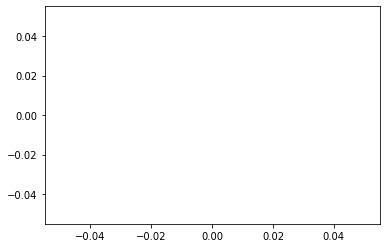

In [143]:
losses = []
for n in range(10):
  print('.', end='')
  logs = translator.train_step([x[:64], y[:64]])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [166]:
translator2 = TrainTranslator(
    embedding_dim, units,
    input_text_vocab = tokenizer_hi.word_index,
    output_text_vocab = tokenizer_en.word_index,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)
translator.use_tf_function = True

In [69]:
BUFFER_SIZE = len(x)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((x,y)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [84]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
training.

In [ ]:
tokenizer_en.texts

In [56]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder,input_tokenizer,output_tokenizer):
    self.encoder = encoder
    self.decoder = decoder
    self.input_tokenizer = input_tokenizer
    self.output_tokenizer = output_tokenizer
    #self.output_token_string_from_index = output_tokenizer.sequences_to_texts()
    #self.output_token_string_from_index = (
     #   tf.keras.layers.experimental.preprocessing.Char(
      #      vocabulary=output_text_vocab,
       #     mask_token='',
       #     invert=True))

    # The output should never generate padding, unknown, or start.
    #index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
       # vocabulary=output_tokenizer.word_index, mask_token='')
    token_mask_ids = 0

    token_mask = np.zeros([len(output_tokenizer.word_index)+1], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = output_tokenizer.word_index['<sos>']
    self.end_token = output_tokenizer.word_index['<eos>']

In [57]:
def sample(self, logits, temperature):
  #shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  #shape_checker(logits, ('batch', 't', 'vocab'))
  #shape_checker(self.token_mask, ('vocab',))
  #logits =tf.squeeze(logits,axis=1)
  
  token_mask = self.token_mask[tf.newaxis,tf.newaxis, :]
  
  #shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

  #shape_checker(new_tokens, ('batch', 't'))

  return new_tokens
def tokens_to_text(self, result_tokens):
  #shape_checker = ShapeChecker()
  #shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_tokenizer.sequences_to_texts(result_tokens.numpy())
  #shape_checker(result_text_tokens, ('batch', 't'))

  #result_text = tf.strings.reduce_join(result_text_tokens,
   #                                    axis=1, separator='')
  #shape_checker(result_text, ('batch'))

  #result_text = tf.strings.strip(result_text)
  #shape_checker(result_text, ('batch',))
  return result_text_tokens
def translate_unrolled(self,
                       input_text, *,
                       max_length=19,
                       return_attention=False,
                       temperature=0.0):
  
  #print(batch_size)
  input_tokens = self.input_tokenizer.texts_to_sequences(input_text)
  input_tokens = kprocessing.sequence.pad_sequences(input_tokens,padding='post')
  #print(input_tokens.T,input_tokens.T.shape)
  input_tokens= input_tokens.T
  batch_size = input_tokens.shape[0]
  input_tokens = tf.constant(input_tokens)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  #print(new_tokens)
  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  
  #print(max_length)
  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)
    #print(dec_result.logits.shape)
    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


Translator.tokens_to_text = tokens_to_text
Translator.sample = sample
Translator.translate = translate_unrolled

In [58]:
translator = Translator(
    encoder=translator.encoder,
    decoder=translator.decoder,
    input_tokenizer=tokenizer_hi,
    output_tokenizer=tokenizer_en,
)

In [63]:
ns = [i for i in range(100,200)]
for i in ns:
  print(translator.translate(hindi[i]), roman[i])

{'text': ['a n t a r r a s h t r i y <UNK>']} antarrashtriye
{'text': ['t a n t a r a t m a <UNK>']} antaratma
{'text': ['t a n t a r a t m a <UNK>']} antratma
{'text': ['t t a n t r a n t r a n t a l a l a l']} antral
{'text': ['n t a r a s h t r i y <UNK>']} antarashtriya
{'text': ['n t a r a s h t r i y <UNK>']} antarrashtriya
{'text': ['n t a r a s h t r i y <UNK>']} antrashtriya
{'text': ['n t r n t r i k s h r i k s h <UNK>']} antariksh
{'text': ['n t r n t r i k s h r i k s h <UNK>']} antriksh
{'text': ['a n t a r i k s h y a t r i <UNK>']} antrikshyatri
{'text': ['t a n t a r k s h a n <UNK>']} antrikshayan
{'text': ['t a n t a r k s h a n <UNK>']} antrikshyaan
{'text': ['t a n t a r k s h a n <UNK>']} antrikshyan
{'text': ['n t t r i m m i m <UNK>']} antarim
{'text': ['n t t r i m m i m <UNK>']} antrim
{'text': ['a n t r o n <UNK>']} antaron
{'text': ['n t g a r g a r g a t <UNK>']} antargart
{'text': ['n t g a r g a r g a t <UNK>']} antargat
{'text': ['n t g a r g a r g a t <

In [91]:
q

'inaka'

In [ ]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
ls = tokenizer.detokenize(inp[0].numpy().tolist()).numpy()
print(ls)
ls = ls.decode('utf-8')
print(ls)

b'\xe0\xa4\x85\xe0\xa4\x82'
अं


In [14]:
df = pd.read_csv(pth_1,sep="\t",names=["Hindi","roman","freq"]) 
df = df[['Hindi','roman']]
hindi = df['Hindi']

In [56]:
x

array([[30, 10,  0, ...,  0,  0,  0],
       [30, 10,  7, ...,  0,  0,  0],
       [30, 10,  7, ...,  0,  0,  0],
       ...,
       [25,  4, 15, ...,  0,  0,  0],
       [25,  4, 15, ...,  0,  0,  0],
       [64,  0,  0, ...,  0,  0,  0]], dtype=int32)